# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
import math  
from scipy.misc import derivative
from scipy import interpolate
import datetime
import plotly.express as px
import time
import osmnx as ox
import networkx as nx
import requests as req,json
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [73]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])

time_interval = TimeSelector(
    '2019-10-29T12:00:00Z', # start time
    '2020-07-03T12:00:00Z' # end time
)

# issue a query
track_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval, num_results=50) # requesting 50 tracks inside the bbox


In [74]:
track_df

,id,time,geometry,Consumption.value,Consumption.unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Accuracy.value,...,GPS HDOP.value,GPS HDOP.unit,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eff53add6e3cf256b3a688e,2020-07-03T15:36:56,POINT (7.63804 51.93936),6.241582,l/h,106.648092,m,19.000000,%,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eff53add6e3cf256b3a6890,2020-07-03T15:37:04,POINT (7.63601 51.93862),2.726338,l/h,107.279862,m,16.000000,%,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eff53add6e3cf256b3a6891,2020-07-03T15:37:09,POINT (7.63472 51.93827),2.346077,l/h,105.635522,m,15.000000,%,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eff53add6e3cf256b3a6892,2020-07-03T15:37:14,POINT (7.63340 51.93803),6.509028,l/h,103.357213,m,22.178631,%,7.431818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eff53add6e3cf256b3a6893,2020-07-03T15:37:19,POINT (7.63198 51.93783),3.812417,l/h,101.427228,m,17.196667,%,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5dc985eb44ea856b702dd986,2019-10-29T16:10:53,POINT (7.59827 51.96493),3.650844,l/h,104.076293,m,16.027855,%,4.000000,...,0.800000,precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,5dc985eb44ea856b702dd987,2019-10-29T16:10:58,POINT (7.59737 51.96492),1.833257,l/h,104.120778,m,14.000000,%,4.000000,...,0.831683,precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,5dc985eb44ea856b702dd988,2019-10-29T16:11:03,POINT (7.59646 51.96492),7.913148,l/h,104.362252,m,32.000001,%,4.000000,...,0.946493,precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,5dc985eb44ea856b702dd989,2019-10-29T16:11:08,POINT (7.59541 51.96499),3.023674,l/h,104.526386,m,16.000000,%,4.618619,...,0.967463,precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define parameters of the car

In [75]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class ( dodge 2007)
Dodge_2007 = Car(3039,2.019,0.30)
##generalcar = car
car = Car()


## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [76]:
#Define the distance equation based on "Jiménez-Meza, A., Arámburo-Lizárraga, J., & de la Fuente, E. (2013). Framework for estimating travel time, distance, speed, and street segment level of service (los), based on GPS data. Procedia Technology, 7, 61-70."

def distance(lon1,lon2,lat1,lat2): 
    b = 69.1 * (lat2 - lat1)
    e = 69.1 * (lon2 - lon1) * np.cos(lat1/57.3)
    d = math.sqrt((b ** 2) + (e ** 2)) * 1609.344
    return d

#define gradient equation
def gradient(height,distance):
    return np.arctan(height/distance)


## Define engine power (KW) equation
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000, power/speed]
    else:
        resistance =(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [P_idle, resistance]
    
# interpolate to find efficiency values based on driving resistance
def interpolation(x):
    A = [-2000, 2000]
    B = [0.1, 0.4]
    f = interpolate.interp1d(A, B)
    efficiency = f(x)
    return efficiency

## Fuel consumption ewuation
def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

# Request elevation values from an open source (opentopodata.org)
url = 'https://api.opentopodata.org/v1/eudem25m?locations='

## put 100 points in each request
def generate_parms(s,e):
    lats= list(one_track[s:e]['geometry'].y)
    lngs = list(one_track[s:e]['geometry'].x)
    track_coords = [c for c in zip(lats, lngs)]
    format_str=list(map(lambda x : str(x[0])+','+str(x[1])+'|', track_coords)) 
    concat_str = ''.join(format_str)
    return concat_str

## send the request
def request(link):
    elevation = req.request('GET',link)
    status =elevation.json()['status']
    if status=='OK':
        results = elevation.json()['results']
        h = list(map(lambda x : x['elevation'], results))
    else:
        h= None
    return h

## Estimate fuel consumption/Co2 emissions for tracks in dataframe

In [77]:
## Make for loop to iterate over the routes and calculate fuel consumption/Co2 emissions to a group of routes together

tracks = pd.DataFrame(columns=track_df.columns)
for i in range (10,30):
    
    # Get the first track
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    
    # estimate the len of data
    batch = [int(len(one_track)/100),len(one_track)%100]
    elevation=[]
    
    # get elevation values
    for i in range(batch[0]+1):
        #create requeest 100 parameter 
        s = i*100
        e = (i+1)*100
        if i<batch[0]+1:
            --e 
        else:
            e= e+batch[1]
            
        ##check the parameters (s) not excced the lenght of the track    
        if s >= len(one_track):
            break
            
        ##creat the request
        parms= generate_parms(s,e)
        
        #send the request and get the results
        access= url+parms
        part = request(access)
        if part==None:
            part=[np.nan]*(e+1-s)
            
        ##put the results in a list
        elevation.extend(part)

        ## It must be at least a second between each requests (Open Top API rules)
        time.sleep(1)
        
    ##assign the elevation to the track points
    one_track['elevation']=elevation
    
    ## check if the open topo does not return elevation value for some points, then use the GPS altitude for them 
    temp=one_track[one_track['elevation'].isnull()==True]
    if len(temp)> 0:
        for i in temp.index:
            one_track.loc[i,'elevation']=one_track.loc[i,'GPS Altitude.value']
    
    
    ## claculate the gradient
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
            
        #getting the coordinates of each point
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        
        #calculate the elevation difference between the two points
        heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
        
        #calculate the distance between the two points/ and the accumulated distance 
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        if i == 0:
            one_track.loc[i,'total_distance'] = 0
            one_track.loc[i+1,'total_distance'] = one_track.loc[i+1,'seg_distance']
        else:
            one_track.loc[i+1,'total_distance']= one_track.loc[i+1,'seg_distance'] + one_track.loc[i,'total_distance']
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        one_track.loc[i,'gradient']= grade
    
    ## Add interval time
    
    #get the timestamp column from the track, convert the timestamp column to sereis
    track_time = one_track[['time']]
    time_track = track_time.iloc[:,0]
    #convert the timestamp to data time
    x = pd.to_datetime(time_track)
    x_list = x.tolist()
    #calculate the time difference in second, and put it in a list
    time_interval = []
    for i in range(len(x_list)):
        if i == 0 :
            time_in_second = 0
            one_track.loc[i,'accumulate_time_interval'] = time_in_second
        else:
            time_in_second = ((x_list[i] - x_list[i-1]).total_seconds())
            one_track.loc[i,'accumulate_time_interval'] = time_in_second + one_track.loc[i-1,'accumulate_time_interval']
            
        time_interval.append(time_in_second)
         
    
    # add the time interval list to the track 
    one_track['time_interval']=time_interval
        
    ## Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] / 3.6
    
    ## calculate acceleration
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        else:
            one_track.loc[i, 'Acceleration'] = (one_track.loc[i+1, 'speed'] - one_track.loc[i, 'speed'])/one_track.loc[i,'time_interval']
    
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
            one_track.loc[i, 'driving_resistance'] = ep[1]
    
    ## Calculates Engine Power for specific car (Dodge 2007)
    for i in one_track.index:
        ep = engine_power(Dodge_2007,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_dodge'] = P_idle
            one_track.loc[i, 'driving_resistance_dodge'] = ep[1]
        else:
            one_track.loc[i, 'eng_pw_dodge'] = ep[0]
            one_track.loc[i, 'driving_resistance_dodge'] = ep[1]
    
    ## calculate the efficiency based on the driving resistance using "interpolation function"
    ## in case there are some Outliers (driving resistance outside the range [-2000,2000]), then use the constant efficiency (0.3) for them
    
    for i in one_track.index:
        res = one_track.loc[i, 'driving_resistance']
        res_dodge = one_track.loc[i, 'driving_resistance_dodge']
        if (res >= 2000 or res <= -2000):
            one_track.loc[i,'efficiency'] = 0.3
        else:
            one_track.loc[i, 'efficiency'] = interpolation(res)
        if (res_dodge >= 2000 or res_dodge <= -2000):
            one_track.loc[i,'efficiency_dodge'] = 0.3
        else:
            one_track.loc[i, 'efficiency_dodge'] = interpolation(res_dodge)            
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, one_track.loc[i,'efficiency']) 
        one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for dodge 2007
    for i in one_track.index:
        dodge_cons = fuel_consumption(one_track.eng_pw_dodge[i],H_g, one_track.loc[i, 'efficiency_dodge']) 
        one_track.loc[i, 'Consumption_dodge'] = dodge_cons    ## liters / hour
        one_track.loc[i, 'CO2_dodge'] = dodge_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

## Filter the data

In [78]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'CO2.value','sensor.model','time_interval','accumulate_time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_dodge', 'Consumption.value', 'Consumption_Gasoline','CO2_Gasoline','geometry' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[13]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval','accumulate_time_interval', 'Acceleration', 'GPS Altitude.value','elevation','gradient', 'engine_power','driving_resistance','efficiency', 'Consumption.value','Consumption_Gasoline','CO2.value','CO2_Gasoline']]
one_track

,time,speed,time_interval,accumulate_time_interval,Acceleration,GPS Altitude.value,elevation,gradient,engine_power,driving_resistance,efficiency,Consumption.value,Consumption_Gasoline,CO2.value,CO2_Gasoline
0,2019-12-29T12:11:19,3.802064,0.0,0.0,inf,45.999999,-0.312093,0.006931,inf,inf,0.300000,2.201733,inf,5.174072,inf
1,2019-12-29T12:11:25,4.543000,6.0,6.0,-0.150064,44.999999,-0.209130,0.001434,0.443981,97.728647,0.257330,3.186081,0.196061,7.487291,0.468587
2,2019-12-29T12:11:30,3.642615,5.0,11.0,-0.702525,44.000000,-0.176606,0.010469,2.000000,-600.675068,0.204949,1.890531,1.108921,4.442747,2.650322
3,2019-12-29T12:11:35,0.129990,5.0,16.0,-0.025998,44.999999,-0.065007,-0.012104,0.010033,77.181431,0.255789,1.771329,0.004457,4.162623,0.010653
4,2019-12-29T12:11:40,0.000000,5.0,21.0,0.000000,45.000001,-0.066134,-0.020263,2.000000,-3.908406,0.249707,1.833710,0.910158,4.309218,2.175278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,2019-12-29T14:36:43,0.000000,5.0,8724.0,0.047910,99.000000,62.675255,0.000137,2.000000,368.178855,0.277613,1.685962,0.818666,3.962010,1.956612
1723,2019-12-29T14:36:48,0.239552,5.0,8729.0,-0.047910,99.000000,62.675323,-0.007448,0.027034,112.850924,0.258464,2.153064,0.011886,5.059700,0.028407
1724,2019-12-29T14:36:53,0.000000,5.0,8734.0,0.000000,100.000003,62.666435,-0.000309,2.000000,289.754600,0.271732,1.690632,0.836387,3.972984,1.998965
1725,2019-12-29T14:36:58,0.000000,5.0,8739.0,0.000000,100.000000,62.666382,0.003368,2.000000,343.854646,0.275789,1.793028,0.824082,4.213616,1.969555


# Sensitivity Analysis

## Comprasion between estimated fuel consumption/CO2 emissions & OBD values 

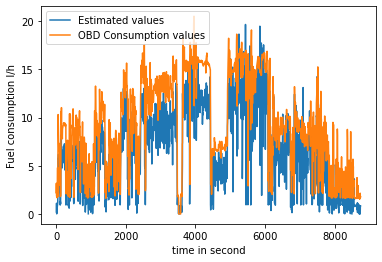

In [79]:
#comrasion between estimated fuel consumption & OBD values
f, axarr = plt.subplots(1)

## get the variables from the track
x = time_interval = np.array(one_track['accumulate_time_interval'])
y1 = np.array(one_track['Consumption_Gasoline'])
y2 = np.array(one_track['Consumption.value'])

## set axes
one = axarr.plot(x,y1, label="Estimated values")
two = axarr.plot(x,y2, label="OBD Consumption values" )

## set labels
axarr.set_xlabel('time in second')
axarr.set_ylabel('Fuel consumption l/h')
axarr.legend()

plt.show()

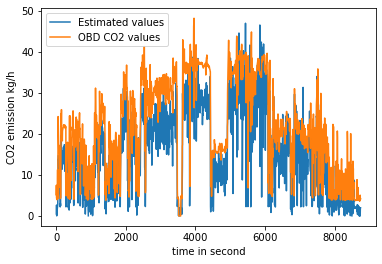

In [80]:
#comrasion between estimated CO2 & CO2 calculated from OBD

f, axarr = plt.subplots(1)

## get the variables from the track
x = time_interval = np.array(one_track['accumulate_time_interval'])
y1 = np.array(one_track['CO2_Gasoline'])
y2 = np.array(one_track['CO2.value'])

## set axes
one = axarr.plot(x,y1, label="Estimated values")
two = axarr.plot(x,y2, label="OBD CO2 values" )

## set labels
axarr.set_xlabel('time in second')
axarr.set_ylabel('CO2 emission kg/h')
axarr.legend()

plt.show()

## Elevation from Open Topo API vs GPS altitude

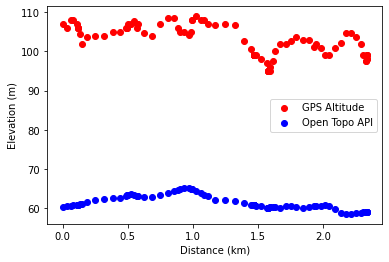

In [81]:
## Select a track
one_track_id = tracks['track.id'].unique()[9]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['total_distance','GPS Altitude.value', 'elevation']]

#Plot the elevation form Open topo Api & GPS altitude

f, axarr = plt.subplots(1)

#set axes
x = np.array(one_track['total_distance']) / 1000  # to convert to km
y1 = np.array(one_track['GPS Altitude.value']) 
y2 = np.array(one_track['elevation'])

#set labels
one = axarr.scatter(x,y1,c='red', label='GPS Altitude')
two = axarr.scatter(x,y2,c='blue', label='Open Topo API')
axarr.set_xlabel('Distance (km)')
axarr.set_ylabel('Elevation (m)')
axarr.legend()

plt.show()

## Plot different variables for one track

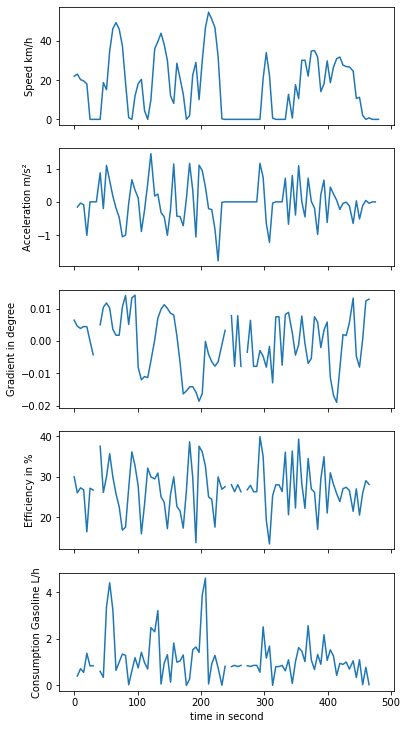

In [82]:
## select a track
one_track_id = tracks['track.id'].unique()[9]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['speed', 'accumulate_time_interval', 'Acceleration','gradient','efficiency','Consumption_Gasoline']]
one_track

## plot different variables for one track
f, axarr = plt.subplots(5, sharex=True)
figsize=(8, 6)

## Get the varaibles from the track
time_interval = np.array(one_track['accumulate_time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
efficiency = np.array(one_track['efficiency']) * 100


## set axis
axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , efficiency)
axarr[4].plot(time_interval , Consumption_Gasoline)


## set labels
axarr[4].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
axarr[3].set_ylabel('Efficiency in %')
axarr[4].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)


## The relationship between consumption and speed/acceleration

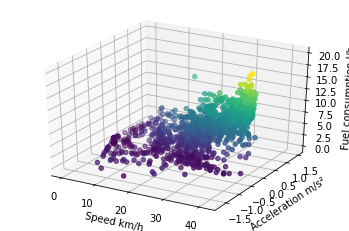

In [98]:
one_track_id = tracks['track.id'].unique()[13]
track = tracks[tracks['track.id'] == one_track_id]
one_track = track[['speed','Acceleration','Consumption_Gasoline']]

#set axes
ax = plt.axes(projection='3d')
zdata = np.array(one_track['Consumption_Gasoline'])
xdata = np.array(one_track['speed']) 
ydata = np.array(one_track['Acceleration'])

#set labels
ax.set_xlabel('Speed km/h')
ax.set_ylabel('Acceleration m/s²')
ax.set_zlabel('Fuel consumption l/h')
ax.scatter3D(xdata, ydata, zdata, c=zdata);

## The fuel consumption between different car models on a given route

In the following section, we plot fuel consumption for the general car and specific car (Dodge 2007). The data of two cars:

|car       | mass(kg)   |crossArea  
|---------:|-------:|----------:|
|general   | 1500   | 2         | 
|Dodge 2007| 3039  |    2.019  | 


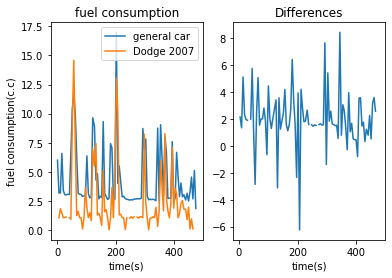

,sensor.manufacturer,sensor.constructionYear,accumulate_time_interval,Consumption.value,Consumption_Gasoline,Consumption_dodge
0,Dodge,2007,0.0,4.314189,inf,inf
1,Dodge,2007,5.0,2.288989,0.402488,0.744859
2,Dodge,2007,10.0,2.290481,0.718678,1.319139
3,Dodge,2007,15.0,4.736077,0.562619,1.044908
4,Dodge,2007,20.0,2.438427,1.381676,0.757576
...,...,...,...,...,...,...
91,Dodge,2007,460.0,3.273769,0.782095,0.684052
92,Dodge,2007,465.0,1.921690,0.036501,0.066330
93,Dodge,2007,470.0,3.689343,NaN,NaN
94,Dodge,2007,475.0,1.325050,0.841169,0.781280


In [87]:
## Select a track
one_track_id = tracks['track.id'].unique()[9]
track = tracks[tracks['track.id'] == one_track_id]
one_track = track[['sensor.manufacturer','sensor.constructionYear','accumulate_time_interval','Consumption.value','Consumption_Gasoline','Consumption_dodge']]


## fuel consumption between different car models
f, axarr = plt.subplots(1,2)

## get the variables
x = np.array(one_track['accumulate_time_interval'])
gc= np.array(one_track['Consumption.value']*1000/720) # 1 cc/5s
sc = np.array(one_track['Consumption_dodge']*1000/720)

## set axes
g1=axarr[0].plot(x,gc,label="general car")
s1=axarr[0].plot(x,sc,label="Dodge 2007")
diff=axarr[1].plot(x,gc-sc)

#set labels
axarr[0].set_xlabel('time(s)')
axarr[1].set_xlabel('time(s)')
axarr[0].set_title('fuel consumption')
axarr[1].set_title('Differences')
axarr[0].set_ylabel('fuel consumption(c.c)')
axarr[0].legend()

plt.show()

one_track

### Compare the resulted fuel consumption with OBD values

the following figures explian that use the specific vehicle parameters would improve the results of load-based model,get more reasonable results and get minimize the error comparingwith OBD values 

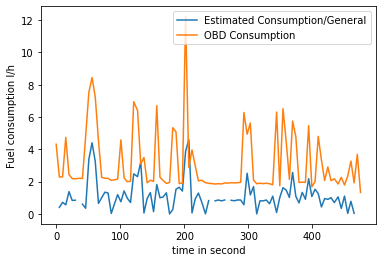

In [88]:
#comrasion between estimated fuel consumption using general parameters & OBD values
f, axarr = plt.subplots(1)

## get the variables from the track
x = time_interval = np.array(one_track['accumulate_time_interval'])
y1 = np.array(one_track['Consumption_Gasoline'])
y2 = np.array(one_track['Consumption.value'])

## set axes
one = axarr.plot(x,y1, label="Estimated Consumption/General")
two = axarr.plot(x,y2, label="OBD Consumption" )

## set labels
axarr.set_xlabel('time in second')
axarr.set_ylabel('Fuel consumption l/h')
axarr.legend()

plt.show()

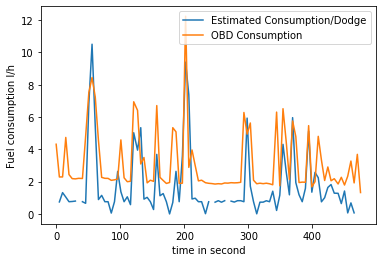

In [89]:
#comrasion between estimated fuel consumption using Dodge & OBD values
f, axarr = plt.subplots(1)

## get the variables from the track
x = time_interval = np.array(one_track['accumulate_time_interval'])
y1 = np.array(one_track['Consumption_dodge'])
y2 = np.array(one_track['Consumption.value'])

## set axes
one = axarr.plot(x,y1, label="Estimated Consumption/Dodge")
two = axarr.plot(x,y2, label="OBD Consumption" )

## set labels
axarr.set_xlabel('time in second')
axarr.set_ylabel('Fuel consumption l/h')
axarr.legend()

plt.show()

## The most efficient driving behaviour on a given route

### Driving behaviour on the route  

In the following section, differnt speed profile (constant speed) tested to check the instantinous fuel consumption/ accuumulated consumption on the route at different speed.

In [90]:
## Define a function to estimate the instantinous/accumulated fuel consumtion for a given track
## In this function different speed profile will be tested (10,20,30,40,50) km/h

def accumulated_consumtion(track,speed):
    # constant speed value
    speed = speed
    acceleration = [0]
    ## creat column to for each speed to store the instantinous fuel consumption 
    columns = ['consumption_speed1', 'consumption_speed2', 'consumption_speed3', 'consumption_speed4', 'consumption_speed5']
    ## creat column to for each speed to store the accumulated  fuel consumption 
    accumulate_consumption = ['accumulate_speed1', 'accumulate_speed2', 'accumulate_speed3', 'accumulate_speed4', 'accumulate_speed5']
    accumulated = 0
    accumulated_fuel = []
    for x in range(0,5):
        test_track.insert(2,columns[x], True)
        for i in test_track.index:
            ep = engine_power(car,0.02,test_track.gradient[i],speed[x]/3.6,acceleration[0])
            if ep[0] < 0:
                test_track.loc[i, 'engine_power'] = P_idle
                test_track.loc[i, 'driving_resistance'] = ep[1]
            else:
                test_track.loc[i, 'engine_power'] = ep[0]
                test_track.loc[i, 'driving_resistance'] = ep[1]
        for i in test_track.index:
            res = test_track.loc[i, 'driving_resistance']
            if (res >= 2000 or res <= -2000):
                test_track.loc[i,'efficiency'] = 0.3

            else:
                test_track.loc[i, 'efficiency'] = interpolation(res)

        ## Instantaneous/Cumulated Fuel consumption
        for i in test_track.index:
            ## estimate Instantaneous consumtion using "fuel_consumption function"
            car_cons = fuel_consumption(test_track.engine_power[i],H_g, test_track.loc[i,'efficiency']) 
            ## assign Instantaneous consumtion for each point 
            test_track.loc[i, columns[x]] = car_cons
            
            ## calculate the consumtion for the time interval 
            acc_cons = (car_cons / 3600)*5
            value = acc_cons

            if value >=0:
                accumulated += value
                
            ## assign the fuel consumption at each point
            test_track.loc[i, accumulate_consumption[x]] = accumulated
            
        ## accumulated Fuel Consumption
        accumulated_fuel.append(accumulated)
        accumulated = 0
    test_track
    return [test_track,accumulated_fuel]


### Plot Instantaneous Fuel consumption at different speed profile (inside the city)

The following graph shows how the fuel consumption affected by change the speed, it is obvious that decrasing the speed in the city from 50km/h to 30km/h would help save fuel and reduce CO2 emissios. 

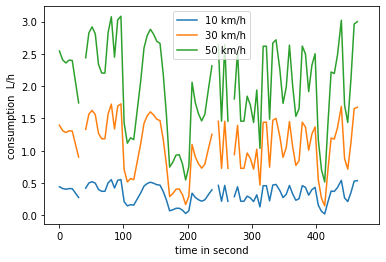

In [91]:
#select a track
one_track_id = tracks['track.id'].unique()[9]
track = tracks[tracks['track.id'] == one_track_id]
test_track = track[['track.length','time','time_interval','accumulate_time_interval', 'speed', 'Acceleration', 'elevation','gradient','total_distance']]

#define different speed profile 
speed = [10, 20, 30, 40, 50] #speed values inside the city in Km/h

#estimate instantinous/accumulated consumption at different speed profile 
test_track,cumulated_fuel  = accumulated_consumtion(test_track, speed)


f, axarr = plt.subplots(1)

## get the instantinous consumption value at each speed from the track 
x = np.array(test_track['accumulate_time_interval'])
consumption_10 = np.array(test_track['consumption_speed1']) 
consumption_20 = np.array(test_track['consumption_speed2'])
consumption_30 = np.array(test_track['consumption_speed3'])
consumption_40 = np.array(test_track['consumption_speed4'])
consumption_50 = np.array(test_track['consumption_speed5']) 

# set axes
one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_30, label="30 km/h")
three = axarr.plot(x,consumption_50, label="50 km/h")

## st labels
axarr.set_xlabel('time in second')
axarr.set_ylabel('consumption  L/h')
axarr.legend()

plt.show()

### Plot accumulated Fuel consumption against speed profile (on highway)

The next plot shows the behavouir of accumulated fuel consumption against speed, you can notice that increasing the speed on the route leads to increase the accumulated fuel consumption on the route.

It shows the aggregated fuel consumption along the route (160 Km) when drive at different speed. 


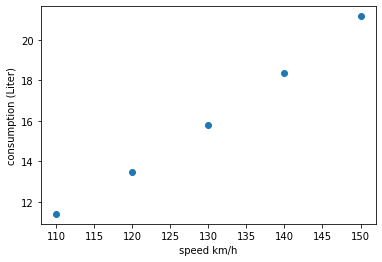

In [92]:
## select a track
one_track_id = tracks['track.id'].unique()[4]
track = tracks[tracks['track.id'] == one_track_id]
test_track = track[['track.length','time','time_interval','accumulate_time_interval', 'speed', 'Acceleration', 'elevation','gradient','total_distance']]

#define different speed profile 
speed = [110, 120, 130, 140, 150] #speed values on the highway in Km/h

## estimate instantinous/accumulated consumption at different speed profile 
test_track,accumulated_fuel = accumulated_consumtion(test_track, speed)

## plot 
f, axarr = plt.subplots(1)

## set axes and labels
x = np.array(speed)
y = np.array(accumulated_fuel) 
one = axarr.scatter(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('consumption (Liter)')

plt.show()

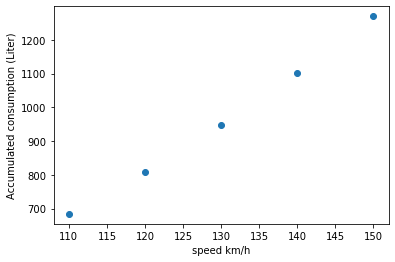

In [93]:
# the accumuated fuel consumtion on the road If 60 cars traverse on the road at the same speed, 
f, axarr = plt.subplots(1)
x = np.array(speed)
y = np.array(accumulated_fuel) * 60
one = axarr.scatter(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('Accumulated consumption (Liter)')
plt.show()

### Plot accumulate Fuel consumption on a route against distance

The following figure shows the accumulated fuel consumption when the car travel the same disatnce but at different speed profile, It is obvious that reduce the speed limits on the highways would save energey/reduce fuel consumption. 

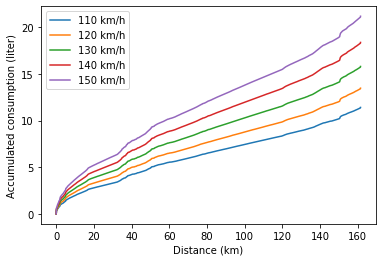

In [94]:
# Accumulate fuel consumption for one car for the same previous route 

f, axarr = plt.subplots(1)

## get the vriables from the track
x = np.array(test_track['total_distance'])/ 1000  # to convert to km
consumption_110 = np.array(test_track['accumulate_speed1'])
consumption_120 = np.array(test_track['accumulate_speed2'])
consumption_130 = np.array(test_track['accumulate_speed3'])
consumption_140 = np.array(test_track['accumulate_speed4'])
consumption_150 = np.array(test_track['accumulate_speed5'])

## set axes and labels
one = axarr.plot(x,consumption_110, label="110 km/h")
two = axarr.plot(x,consumption_120, label="120 km/h" )
three = axarr.plot(x,consumption_130, label="130 km/h")
four = axarr.plot(x,consumption_140, label="140 km/h")
five = axarr.plot(x,consumption_150, label="150 km/h")
axarr.set_xlabel('Distance (km)')
axarr.set_ylabel('Accumulated consumption (liter)')
axarr.legend()

plt.show()

## The most efficient route

The following map shows different routes, visualized depending on the fuel consumption to let the user now which is the most efficient route. 

In [168]:
tracks['lat'] = tracks['geometry'].apply(lambda coord: coord.y)
tracks['lng'] = tracks['geometry'].apply(lambda coord: coord.x)
tracks.dropna()
fig = px.scatter_mapbox(tracks, lat="lat", lon="lng", color="Consumption_Gasoline")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## The fastest/shortest route


The following network build based on OSM for the same study area, then used the nwteork to find the fastest route between two points (based on time) if the speed value is the maximun speed allowed on the route.

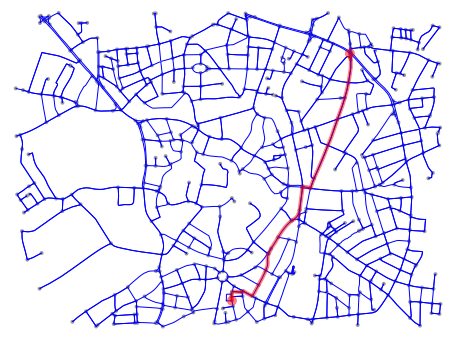

In [170]:
#The shortest route
G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')

#chnge the start point "G"  & the end point "dest" to see different route
orig = list(G)[2]
dest = list(G)[-1]

# add the missing values
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}

G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

# find the fastest/shortest route depend on length

route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route, edge_color= 'blue')

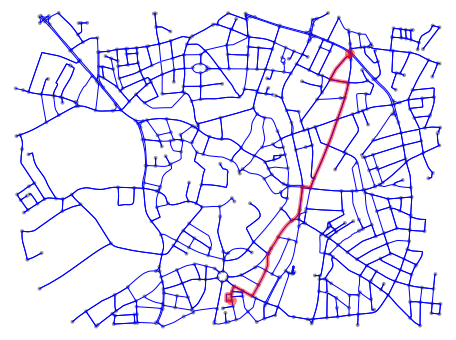

In [39]:
# The fastest route depend on time
orig = list(G)[2]
dest = list(G)[-1]
route1 = nx.shortest_path(G, orig, dest, weight='time')

fig, ax = ox.plot_graph_route(G, route1, edge_color= 'blue')

## The most efficient route 

The following cells used to match the routes with OSM, and assign the estimated CO2 emissions on the road to the OSM segment, then build a network to cfind the most efficient route between two points.

One limitation of this method, the routes not cover the whole OSM that leads to assign (0) CO2 emissions for edges not cover by the routes, that affect the network ad find the most efficient route.  

In [40]:
## extract the OSM network and assign the CO2 emmisions

nodes, streets = ox.graph_to_gdfs(G)

ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color='#333333', edge_width=1, edge_opacity=1)
streets1 = streets
allstreets = pd.DataFrame(columns=streets.columns)
l = [0] * len(streets)

for i in range (0,19):
    one_track_id = tracks['track.id'].unique()[i]
    one_track = tracks[tracks['track.id'] == one_track_id]
    for i in one_track.index:
        
        lat= one_track.loc[i,'geometry'].y
        lng= one_track.loc[i,'geometry'].x
        
        ## get the nearest edge and the index of the edge 
        u1,v1,key = (ox.get_nearest_edge(G, (lat, lng)))
        index = streets1[(streets1.u ==u1) & (streets1.v ==v1)].index
        num = index.array[0]
        
        ## put the value of co2 in a list assoiciated with index number of the edge
        value = one_track.loc[i,'CO2_Gasoline']
        if value> 0:
            l[num]+= value

## assing the co2 values to the street network
streets1['co2']=l 

## create the graph usng the new street edges with co2 values
graph2 = ox.graph_from_gdfs(nodes, streets1)

### The most eco-efficient(least Co2 emissions) route 

The least CO2 route is longer than the most time efficient route, because some segments were not enlisted in GPS tracks and the CO2 value is zero, but choosing just the segments that have estimated co2 values will show less co2 emissions comparison with the previous plot.

Future work needs traffic simulation to cover a whole network will be necessary in order to derive the least CO2 emissions route.

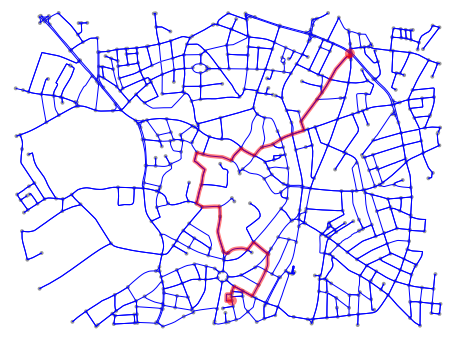

In [41]:
orig = list(graph2)[2]
dest = list(graph2)[-1]
route2 = nx.shortest_path(graph2, orig, dest, weight='co2')

fig, ax = ox.plot_graph_route(graph2, route2, edge_color= 'blue')